<a href="https://www.kaggle.com/code/yashrajojha28/esophagus-cancer-detection?scriptVersionId=116087758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# VGG16

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt

# from keras.optimizers import SGD, RMSprop
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras import backend as K
import plotly.graph_objects as go
import plotly.offline as py
autosize =False

from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

In [2]:
x_train = np.load('/kaggle/input/esophageal-endoscopy-images-resized/esophagus-cancer-files/x_train_128.npy')
x_train.shape

(10662, 128, 128, 3)

In [3]:
y = pd.read_csv('/kaggle/input/esophageal-endoscopy-images-resized/esophagus-cancer-files/traindata.csv').target
y.shape

(10662,)

In [4]:
from sklearn.utils import class_weight
 
class_weights = class_weight.compute_class_weight(class_weight="balanced",classes=np.unique(y),y=y)

In [5]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5941156803744567, 1: 3.1563055062166963}

In [6]:
#splitting the dataset
from sklearn.model_selection import train_test_split
train_imgs, validation_imgs, y_train, y_val = train_test_split(x_train,y, test_size=0.2, random_state=1234)
train_imgs, test_imgs, y_train, y_test = train_test_split(train_imgs,y_train, test_size=0.1, random_state=1234)

In [7]:
test_imgs.shape

(853, 128, 128, 3)

In [8]:
batch_size = 128
num_classes = 2
epochs = 50
input_shape = (128,128,3)

In [9]:
opt = Adam(lr=1e-5)

nb_train_steps = train_imgs.shape[0]//batch_size
nb_val_steps=validation_imgs.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 59 and 16


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

# no need to create augmentation images for validation data, only rescaling the pixels
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, y_train, batch_size=32)
val_generator = val_datagen.flow(validation_imgs, y_val, batch_size=32)

### Activating the trainable layers

In [11]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

2023-01-11 12:33:32.872656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 12:33:33.077614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 12:33:33.078475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 12:33:33.080583: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f343572c310>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f3434d34f10>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f34bd9a2d10>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f3434c9e550>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f3434cac710>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f3434cacb10>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f3434b365d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f3434b3ad90>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f3434b409d0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f3434cb0d10>,block3_conv3,False


In [12]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f343572c310>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f3434d34f10>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f34bd9a2d10>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f3434c9e550>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f3434cac710>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f3434cacb10>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f3434b365d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f3434b3ad90>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f3434b409d0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f3434cb0d10>,block3_conv3,False


Adding layers for classification

In [13]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
____________________________________

In [15]:
model.fit_generator(train_generator, steps_per_epoch=nb_train_steps, epochs=epochs,
                              validation_data=val_generator, validation_steps=nb_val_steps,class_weight=class_weights, 
                              verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

2023-01-11 12:33:38.830682: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-11 12:33:41.580584: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


59/59 [==============================] - 19s 167ms/step - loss: 0.4920 - auc: 0.8371 - val_loss: 0.2051 - val_auc: 0.9770
Epoch 2/50
59/59 [==============================] - 8s 134ms/step - loss: 0.2250 - auc: 0.9619 - val_loss: 0.1412 - val_auc: 0.9839
Epoch 3/50
59/59 [==============================] - 8s 137ms/step - loss: 0.1281 - auc: 0.9901 - val_loss: 0.0968 - val_auc: 0.9977
Epoch 4/50
59/59 [==============================] - 8s 134ms/step - loss: 0.1231 - auc: 0.9884 - val_loss: 0.0566 - val_auc: 0.9960
Epoch 5/50
59/59 [==============================] - 8s 129ms/step - loss: 0.0887 - auc: 0.9939 - val_loss: 0.0599 - val_auc: 0.9978
Epoch 6/50
59/59 [==============================] - 8s 131ms/step - loss: 0.1042 - auc: 0.9922 - val_loss: 0.0341 - val_auc: 0.9988
Epoch 7/50
59/59 [==============================] - 8s 136ms/step - loss: 0.0797 - auc: 0.9947 - val_loss: 0.0695 - val_auc: 0.9932
Epoch 8/50
59/59 [==============================] - 9s 144ms/step - loss: 0.0864 - auc

In [16]:
#saving model
import tensorflow as tf
model.save('vgg-esophagus-model.h5')

In [17]:
from numpy import expand_dims
def tta_prediction(datagen, model, image, n_examples):
    # convert image into dataset
    samples = expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    probs = model.predict_generator(it, steps=n_examples, verbose=0)
    #print(len(probs))    
    prob = np.mean(probs, axis=1)    
    return prob

In [18]:
from tqdm import tqdm
# configure image data augmentation
test_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

In [19]:
test_imgs.shape

(853, 128, 128, 3)

In [20]:
targetvalues=[]
#i = 0
for img in tqdm(test_imgs):
    prediction=tta_prediction(test_datagen,model,img,32)
    pred_y = prediction[0]
    val=0
    if pred_y>0.5:
        val=1
    targetvalues.append(val)

  0%|          | 0/853 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

100%|██████████| 853/853 [00:49<00:00, 17.37it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       723
           1       0.99      0.99      0.99       130

    accuracy                           1.00       853
   macro avg       1.00      1.00      1.00       853
weighted avg       1.00      1.00      1.00       853



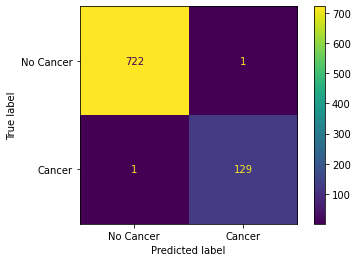

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
import sklearn.metrics as metrics
cm=confusion_matrix(y_test, targetvalues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Cancer", "Cancer"])
cm_display.plot()
print(classification_report(y_test, targetvalues))

Manual Testing

In [22]:
from PIL import Image
def preprocess_image(image_path, desired_size=128):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

In [23]:
import os
esotest = '/kaggle/input/esophagustestset/test/esophagus'
noesotest = '/kaggle/input/esophagustestset/test/no-esophagus'
esotestlist = os.listdir(esotest)
noesotestlist = os.listdir(noesotest)
testlist = []
for name in esotestlist:
    testlist.append(esotest+'/'+name)
for name in noesotestlist:
    testlist.append(noesotest+'/'+name)

In [24]:
testlabels = []
for i in range(40):
    if i<20:
        testlabels.append(1)
    else:
        testlabels.append(0)

In [25]:
N = 40
imSize = 128
# create an empty matrix for storing the images
testset = np.empty((40, imSize, imSize, 3), dtype=np.uint8)

# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
for i, image_id in enumerate(tqdm(testlist)):
    testset[i, :, :, :] = preprocess_image(
        image_id
    )

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.

100%|██████████| 40/40 [00:01<00:00, 26.27it/s]


In [26]:
predval = []
for img in tqdm(testset):
    prediction=tta_prediction(test_datagen,model,img,1)
    pred_y = prediction[0]
    val=0
    if pred_y>0.5:
        val=1
    predval.append(val)

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

100%|██████████| 40/40 [00:02<00:00, 16.44it/s]


Testing the model accuracy manually

In [27]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(testlabels,predval)*100)
print(confusion_matrix(testlabels, predval))

87.5
[[18  2]
 [ 3 17]]
